In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import muon as mu
from muon import prot as pt
import os
import h5py
from mudata import MuData
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.sparse import csr_array
import anndata as ad

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/si

In [2]:
sc.set_figure_params(frameon=False, figsize=(4, 4))

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
from sklearn.mixture import GaussianMixture  # different in updated sklearn (prev GMM)
from sklearn.metrics import confusion_matrix
from matplotlib.colors import rgb2hex

In [5]:
adata = mu.read('/Users/anasuyadighe/Downloads/20230616_GAP-hashed-persamplenorm-iter2.h5mu')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [6]:
rna = adata.mod['rna']
prot = adata.mod['prot']

In [7]:
rna_sing = rna[rna.obs['hashing'].str.contains('1.0')]
prot_sing = prot[rna_sing.obs_names]
#adata.obsm['prot'] = mdata.mod['prot'][adata.obs_names, :] 

In [8]:
hash_data = prot[:, :6].copy().to_df()
hash_data['sample'] = prot.obs['sample']

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


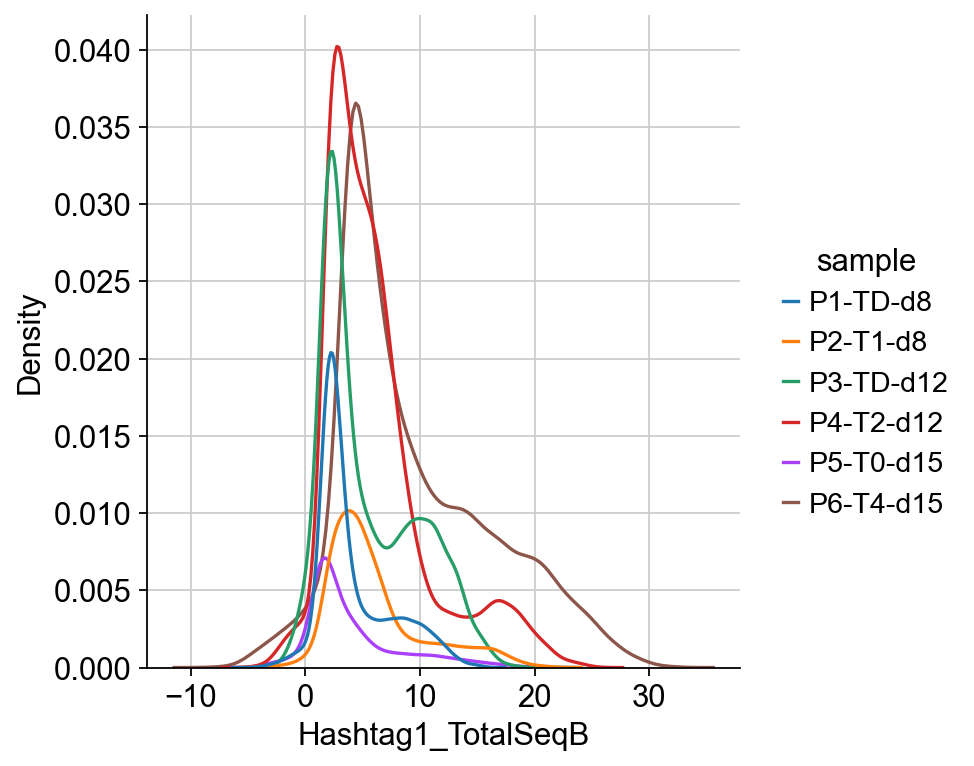

In [9]:
sc.tl.leiden(rna)
hash_data = hash_data.loc[rna.obs_names.values]
hash_data['leiden'] = rna.obs['leiden']
# updating to include leiden clustering (to distinguish CD45 +/-)
sns.displot(data=hash_data, x="Hashtag1_TotalSeqB", hue="sample", kind="kde")

In [10]:
hash_onoff = np.zeros((hash_data.shape[0], hash_data.shape[1]-2))
hash_dict = {'P1-TD-d8': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P2-T1-d8': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P3-TD-d12': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB'],
             'P4-T2-d12': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P5-T0-d15': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag5_TotalSeqB', 'Hashtag6_TotalSeqB'],
             'P6-T4-d15': ['Hashtag1_TotalSeqB', 'Hashtag2_TotalSeqB', 'Hashtag3_TotalSeqB', 'Hashtag4_TotalSeqB']}

In [11]:
hashtag_dict = {0: 'Hash 1',
                1: 'Hash 2',
                2: 'Hash 3',
                3: 'Hash 4',
                4: 'Hash 5',
                5: 'Hash 6'}

In [12]:

rna_sing.obs['hashtag'] = np.argmax(hash_onoff[np.where(rna.obs['hashing'].str.contains('1.0'))], axis=1)
rna_sing.obs['hashtag'] = rna_sing.obs['hashtag'].map(hashtag_dict)
prot_sing.obs['hashtag'] = rna_sing.obs['hashtag']

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_38234/301111281.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rna_sing.obs['hashtag'] = np.argmax(hash_onoff[np.where(rna.obs['hashing'].str.contains('1.0'))], axis=1)
/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_38234/301111281.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  prot_sing.obs['hashtag'] = rna_sing.obs['hashtag']


In [13]:
mdata_sing = MuData({"rna": rna_sing, "prot": prot_sing})

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1169: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if groups and is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


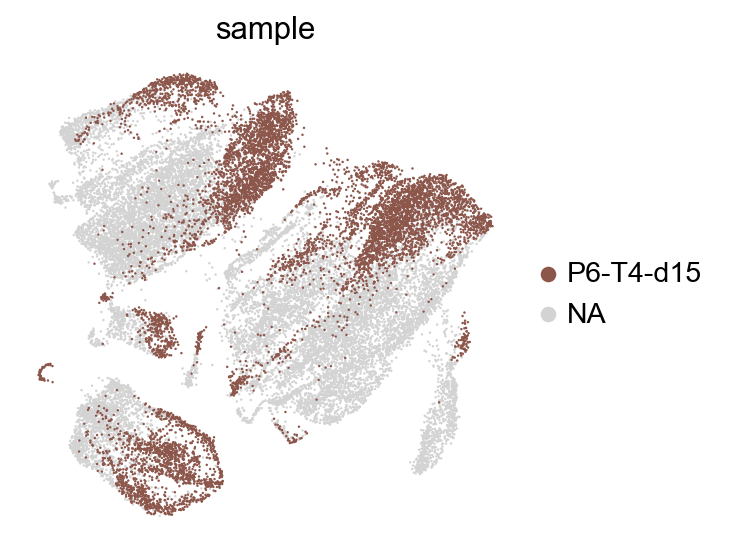

In [14]:
sc.tl.pca(rna_sing, svd_solver='arpack')
sc.pp.neighbors(rna_sing, n_neighbors=15, n_pcs=50)
sc.tl.umap(rna_sing)
sc.pl.umap(rna_sing, color='sample', groups=['P6-T4-d15'])

In [15]:
leiden_map = {'0': 'CD45-', '1': 'CD45+'}
rna_sing.obs['CD45'] = rna_sing.obs['leiden'].map(leiden_map)

In [41]:
def training_data_select(data, marker, celltypes, cell_types, correct_ind):
    '''

    :param data: input sc data (as anndata)
    :param marker: marker genes (listed in array)
    :param celltypes: matrix indicating which genes correspond to which cell type
    :param cell_types: array indicating which cell types we're searching for
    :param correct_ind: patch to exclude subsets if necessary. default - np.arange(len(celltypes))
    :return labels: cell type labels for ideal examples of each expected cell type
    :return ideal_index: indices of the ideal cells in the total data set (important for reshuffling later on)
    :return training_cells: the expression profiles for these ideal cells
    :return test_cells: the remainder of the data set (those not chosen as ideal examples). provides us with training/
    testing split for the neural network classifier
    '''

    # finding the columns corresponding to each marker gene
    ind = np.zeros(len(marker))
    for i in range(len(ind)):
        ind[i] = np.where(data.var_names == marker[i])[0][0]  # just the index number

    on_off = np.zeros((data.X.shape[0], len(marker)))  # number cells x number marker genes - to store binary expr

    # fitting GMMS for each marker gene in master list
    for j in range(len(marker)):  # for each marker gene for each cell type
        expr = data[:, marker[j]].X.reshape(-1, 1).toarray()   # reshaping to one dimensional array for further analysis
        # print(expr)

        # fit models with 1-5 components
        N = np.arange(1, 6)  # fitting models with 1-5 components (not > 5 for simplicity's sake)
        models = [None for p in range(len(N))]

        # fitting a GMM for each possible component combo
        for k in range(len(N)):
            # models[k] = GaussianMixture(N[k]).fit(expr.toarray())
            models[k] = GaussianMixture(N[k]).fit(expr)

        # compute the AIC and the BIC
        AIC = [m.aic(expr) for m in models]
        BIC = [m.bic(expr) for m in models]  # Lauffenburger paper chooses best GMM by minimizing BIC

        # example for plotting BIC by number of Gaussian components
        # plt.plot(N, BIC, marker='o')
        # plt.xlabel('Number of Gaussian components in fitted GMM')
        # plt.ylabel('Bayesian information criterion (BIC)')
        # plt.show()

        # choosing best model and determining which cells are ON/OFF
        M_best = models[np.argmin(BIC)]  # best GMM by minimizing BIC
        x = np.linspace(-0.5, np.max(expr), len(expr))
        logprob = M_best.score(x.reshape(-1, 1))
        pdf = np.exp(logprob)  # will allow us to understand percentiles of marker gene expression

        # need cluster membership based on chosen model - this will determine ON/OFF states
        gmm_labels = M_best.predict(expr)
        gmm_avg = np.zeros(len(np.unique(gmm_labels)))
        for h in np.unique(gmm_labels):
            gmm_ind = np.where(gmm_labels == h)[0]
            gmm_avg[h] = np.mean(expr[gmm_ind])

        ind_min = np.argmin(expr)  # to identify GMM cluster with smallest mean
        ind_max = np.argmax(expr)  # to identify GMM cluster with largest mean

        if len(np.unique(gmm_labels)) > 2:
            ind_sort = np.argsort(gmm_avg)
            on_marker0 = np.where(gmm_labels != ind_sort[0])[0]
            on_marker1 = np.where(gmm_labels != ind_sort[1])[0]
            on_marker = np.intersect1d(on_marker0, on_marker1)

        else:
            on_marker = np.where(gmm_labels != gmm_labels[ind_min])[0]  # on for cells not in smallest cluster

        # now need to make on/off determinations for each cell in data set
        for i in range(len(on_marker)):  # for indices of the proper cluster membership
            on_off[on_marker[i], j] = 1

    labels = []
    ideal_index = []

    for i in correct_ind:  # for each cell type - intended for easy exclusion of cell subtypes with extra logic
        test_on = np.where(celltypes[i, :] == 1)[0]  # indices of ON marker genes
        # code currently not set up to handle cell types with no ON genes
        for j in range(data.X.shape[0]):  # for each cell in data set
            # want to hold on to ideal cells and their cell type label
            ongenes = on_off[j, test_on]
            all_on = np.sum(ongenes)
            if all_on == len(test_on):
                # now need to include check for OFF
                test_off = np.where(celltypes[i, :] == -1)[0]
                if test_off.shape[0] == 0 or np.sum(on_off[j, test_off]) == 0:
                    # one last check for maybe genes...
                    test_mayb = np.where(celltypes[i, :] == 2)[0]
                    if test_mayb.shape[0] == 0 or np.sum(on_off[j, test_mayb]) >= 2:  # no more than one exception
                        # should probably make this an adaptable/user defined threshold
                        labels.append(i)
                        ideal_index.append(j)

    # removing cells that have been classified as more than one cell type
    doub = np.array([x for x in ideal_index if ideal_index.count(x) > 1])
    g = np.array([])
    for i in range(len(doub)):
        g = np.hstack((g, np.where(ideal_index == doub[i])[0]))  # indices of doubled elements

    ideal_index = np.delete(np.asarray(ideal_index), g.astype('int'))
    labels = np.delete(np.asarray(labels), g.astype('int'))  # converted to numpy array

    training_cells = data.X[ideal_index, :]

    print('Percent of data chosen for training set: ', len(labels)/data.X.shape[0])

    print('Cell type breakdown:')
    for k in range(len(cell_types)):
        perc = np.where(labels == k)[0]
        print('{}: {}'.format(cell_types[k], len(perc)))

    # returning test_cells - remainder of data set
    indices = np.arange(0, data.X.shape[0]).tolist()
    test_ind = np.delete(indices, ideal_index)
    test_cells = data.X[test_ind, :]
    
    
    return labels, ideal_index, training_cells, test_cells


def viz_training_data(tot_data, tot_lab, tot_ideal_ind, types, emb, emb_type, cmap_dict, title, fig_size, leg_adjust):
    '''

    :param tot_data: sc data from which a training set is being selected (anndata)
    :param tot_lab: labels assigned for ideal cell type examples
    :param tot_ideal_ind: indices of ideal examples
    :param types: expected cell types (listed explicitly)
    :param emb: 2D tSNE (or other 2D projection) embedding for total dataset
    :param emb_type: string of 2D embedding type, e.g. 'UMAP'
    :param cmap_dict: colormap of choice (used to label different cell types in visually pleasing manner), dictionary or subscriptable colors
    :param title: title of output figure
    :param fig_size: figure size (int, int)
    :param leg_adjust: adjustment (if necessary) to force legend within window
    :return:
    '''
    # need to establish indices in original data for training and testing data split
    indices = np.arange(0, tot_data.shape[0])
    test_ind = np.delete(indices, tot_ideal_ind)
    all_labels = np.zeros(tot_data.shape[0])

    # establishing a label array defining ideal examples + test data
    for i in range(len(tot_ideal_ind)):
        all_labels[tot_ideal_ind[i]] = tot_lab[i]
    for j in range(len(test_ind)):
        all_labels[test_ind[j]] = -1

    fig, ax = plt.subplots(figsize=fig_size)
    scatter_x = emb[:, 0]
    scatter_y = emb[:, 1]
    for g in np.unique(all_labels):
        i = np.where(all_labels == g)
        if g == -1:
            ax.scatter(scatter_x[i], scatter_y[i], label='Test data', c='xkcd:light grey', alpha=0.75, s=6)
        else:
            ax.scatter(scatter_x[i], scatter_y[i], label=int(g), c=cmap_dict[int(g)], s=6)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 8})
    plt.title(title)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    plt.xlabel(emb_type + '1')
    plt.ylabel(emb_type + '2')
    plt.subplots_adjust(right=leg_adjust)
    plt.show()


def one_hot_encode(labels):
    '''
    :param labels: cell type labels
    :return: labels_onehot: the same cell type labels, just one hot encoded
    '''
    labels_onehot = np.zeros((len(labels), len(np.unique(labels))))
    for i in range(len(labels)):
        labels_onehot[i, labels[i]] = 1

    return labels_onehot


def cell_type_classifier(ideal_labels, ideal_cells, test_cells, train_ind, learning_rate, training_epochs, batch_size, display_step):
    '''

    :param ideal_labels: cell type labels for ideal examples
    :param ideal_cells: "ideal" examples of each cell type as selected by the above function
    :param test_cells: cells that aren't in training/validation set
    :param train_ind: indices for random selection of ideal cells for training set. Remainder of ideal reserved for validation
    :param learning_rate: controls increments by which neural network can change during training epochs
    :param training_epochs: the number of iterations over which the neural network is allowed to learn
    :param batch_size: size of subsets of training data tested during each training epoch
    :param display_step: how frequently the training epoch cost is displayed
    :return: pred_lab: cell type labels assigned to each cell in the testing data set
    :return: likelihood: probability value associated with the assigned cell type label
    '''

    labels = ideal_labels[train_ind.astype('int'), :]  # 2D one hot encoded labels
    training_cells = ideal_cells[train_ind.astype('int'), :]

    valid_ind = np.delete(np.arange(len(ideal_labels)), train_ind.astype('int'))
    valid_lab = ideal_labels[valid_ind.astype('int'), :]
    valid_cells = ideal_cells[valid_ind.astype('int'), :]
    valid_cells = valid_cells.todense()
    rows = training_cells.shape[1]

    x = tf.placeholder(tf.float32, [None, rows])  # data shape
    y = tf.placeholder(tf.float32, [None, labels.shape[1]])

    # hidden layer variables + transformation
    W_3 = tf.Variable(tf.truncated_normal([rows, 750], stddev=1e-4))
    b_3 = tf.Variable(tf.random_normal([750]))

    hidden = tf.nn.relu(tf.matmul(x, W_3) + b_3)

    # set model weights + biases - can alter width of this hidden layer
    W = tf.Variable(tf.truncated_normal([750, labels.shape[1]], stddev=1e-4))  # originally 130, can be altered
    b = tf.Variable(tf.random_normal([labels.shape[1]]))

    # after hidden layer - nonlinearity could go here
    after = tf.matmul(hidden, W) + b

    # output layer
    pred = tf.nn.softmax(after)  # softmax is final 3rd layer

    # minimize error using cross entropy [could choose alternate entropy eqn here]
    cost = tf.reduce_mean(-tf.reduce_sum(y * tf.log(pred + 1e-10), reduction_indices=1))
    # issue with log function if/when pred output hits 0
    # simplest fix here to stay nonzero (can also consider clipping, built in tensorflow functions?)

    # gradient descent optimization
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(training_cells.shape[0] / batch_size)
            # Loop over all batches
            for i in range(total_batch):
                # batch x is random sample from training cells
                # batch y is random sample from training cell LABELS - using batch helps with overfitting
                rand_ind = np.arange(0, training_cells.shape[0])
                rand = np.random.choice(rand_ind, batch_size)
                batch_xs = training_cells[rand, :].todense()  # batch_size random # cells
                #batch_xs = training_cells[rand, :]
                batch_ys = labels[rand, :]

                # Run optimization op (backprop) and cost op (to get loss value)
                _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
                # Compute average loss
                avg_cost += c / total_batch
            # Display logs per epoch step
            if (epoch + 1) % display_step == 0:
                print("Epoch:", '%04d' % (epoch + 1), "cost=", "{:.9f}".format(avg_cost))

        print("Optimization Finished!")

        # evaluate accuracy of classification with validation set
        correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
        #accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float64))
        accuracy = tf.compat.v1.reduce_mean(tf.cast(correct_prediction, tf.float32))
        

        print("Accuracy:", accuracy.eval({x: valid_cells,
                                          y: valid_lab}))

        # confusion matrix generation for validation set
        x_batch, y_true_batch = valid_cells, valid_lab
        feed_dict = {
            x: x_batch,
            y: y_true_batch,
        }
        true = sess.run(pred, feed_dict=feed_dict)
        lab_not_hot = np.argmax(valid_lab, axis=1)
        prediction = np.argmax(true, axis=1)
        colorm = confusion_matrix(lab_not_hot, prediction)

        # testing data (aka the rest of the data set)
        true1 = sess.run(pred, feed_dict={x: test_cells.todense()})  # need to evaluate the readout here
        likelihood = np.amax(true1, axis=1)
        pred_lab = np.argmax(true1, axis=1)

    return pred_lab, likelihood, colorm, pred


def process_label(tot_prob, tot_lab, total_predicted_lab, tot_ideal_ind, total_data, thresh):
    '''

    :param tot_prob: the probability values associated with the assigned cell type labels, important info when setting
    confidence threshold
    :param tot_lab: cell type labels associated with the ideal (training/valid) data set
    :param total_predicted_lab: cell type labels output by the neural network
    :param tot_ideal_ind: indices of the ideal data set within the total data set, important for reshuffling cell
    type labels to their proper order wrt the original dataset
    :param total_data: for shape of total dataset
    :param thresh: threshold to distinguish "poorly classified" cells
    :return: total_lab_reshuff: the cell type classification labels put back into the proper order
    '''

    # 0. thresholding based on likelihood
    total_predicted_lab_ = np.zeros(len(total_predicted_lab))
    for k in range(len(tot_prob)):
        if tot_prob[k] < thresh:
            total_predicted_lab_[k] = -1
        else:
            total_predicted_lab_[k] = total_predicted_lab[k]

    # 1. reordering
    indices = np.arange(0, total_data.X.shape[0])
    test_ind = np.delete(indices, tot_ideal_ind.astype('int'))
    total_lab_reshuff = np.zeros(total_data.X.shape[0])
    tot_prob_reshuff = np.zeros(total_data.X.shape[0])

    for i in range(len(tot_ideal_ind)):
        total_lab_reshuff[tot_ideal_ind[i]] = tot_lab[i]
        tot_prob_reshuff[tot_ideal_ind[i]] = 1.01  # encoding "ideal" cells in probability info
    for j in range(len(test_ind)):
        total_lab_reshuff[test_ind[j]] = total_predicted_lab_[j]
        tot_prob_reshuff[test_ind[j]] = tot_prob[j]

    return total_lab_reshuff, tot_prob_reshuff

In [17]:
marker = ['Cd3d','Cd3e','Cd3g','Cd4','Foxp3','Il2ra','Cd8a',
            'Ncr1','Klri2','Csf1r','Itgam','Cd68','Ccr7',
            'Clec9a','Naaa','Xcr1','Cd79a','Pax5','Cd19','Clec10a','Cd209a','Tcf4',
            'Siglech','Plac8','Ighm','Lcn2','Cxcr2','Hdc',
            'Cma1','Cpa3','Tpsb2','Tpsab1','Ms4a2','Mcpt8','Col1a1','Dcn',
            'Vwf','Tek','Pecam1','Perp','Apoe','Krt14','Des','Rgs5','Acta2',
            'Cxcl14','Ucp2','Cd74','Sox9','Sox10','Lgals7','Col6a3',
            'Aqp1','Cacnb3','Fscn1','Ptprc'
          ]

cell_types = ['CD4 T cell','CD8 T cell','Treg','NK','B cell','cDC1','cDC2','pDC',
              'Mono/Macrophage','Neutrophil','Mast cell','Basophil',
              'Fibroblast/Adipocyte','Endothelial','Keratinocyte',
              'Pericyte/SMC','Fibro-adipogenic progenitor','Melanocyte','Tumor cell','mregDC']

In [61]:
celltypes = np.zeros((len(cell_types), len(marker)))
celltypes[0, :7] = [1, 1, 1, 1, -1, -1, -1]  # CD4+
celltypes[1, :7] = [1, 1, 1, -1, -1, -1, 1]  # CD8+
celltypes[2, :7] = [1, 1, 1, 1, 1, 0, -1]  # Treg
celltypes[3, :3] = [-1, -1, -1]  # NK
celltypes[3, 7:9] = [1, 1] #NK
celltypes[:4, 9:12] = -1*np.ones((4, 3))
celltypes[4,16:19] = [1,1,1] # B cell
celltypes[5,13:16] = [1,1,1] #cDC1 
celltypes[6,19:21] = [1,1] #cDC2
celltypes[7,21:25] = [1,1,1,1] #pDC
celltypes[8, :3] = [-1,-1,-1] #Monocyte/macrophage
celltypes[8, 9:12] = [1,1,1] #Monocyte/macrophage
celltypes[9,25:28] = [1,1,1] #neutrophil
celltypes[10,28:32] = [1,1,1,1] #mast cell
celltypes[11,32:34] = [1,1] #basophil
celltypes[12,34:36] = [1,1] #fibroblast/adipocyte
celltypes[13,36:39] = [1,1,1] #endothelial
celltypes[14,39:42] = [1,1,1] #keratinocyte
celltypes[15,42:45] = [1,1,1] #pericyte
celltypes[16,45:48] = [1,1,1] #fibro-adipogenic progenitor
celltypes[17,49:50] = [1] #melanocyte
celltypes[18,50:53] = [1,1,1] #tumor cell
celltypes[19,53:56] = [1,1,1] #mregDC
celltypes[19,12:13] = [1] #mregDC
celltypes[:12,55:56] = [1] #All immune cells marked Cd45+

In [55]:
celltypes[0].shape

(56,)

In [62]:
tot_lab, tot_ideal_ind, tot_traindata, tot_testdata = training_data_select(rna_sing, marker, celltypes, cell_types,np.arange(len(cell_types)))

Percent of data chosen for training set:  0.3598721023181455
Cell type breakdown:
CD4 T cell: 69
CD8 T cell: 203
Treg: 86
NK: 96
B cell: 45
cDC1: 20
cDC2: 31
pDC: 26
Mono/Macrophage: 1317
Neutrophil: 216
Mast cell: 47
Basophil: 10
Fibroblast/Adipocyte: 1547
Endothelial: 138
Keratinocyte: 59
Pericyte/SMC: 60
Fibro-adipogenic progenitor: 202
Melanocyte: 14
Tumor cell: 4509
mregDC: 309


In [20]:
sasha_trubet = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff', '#000000']

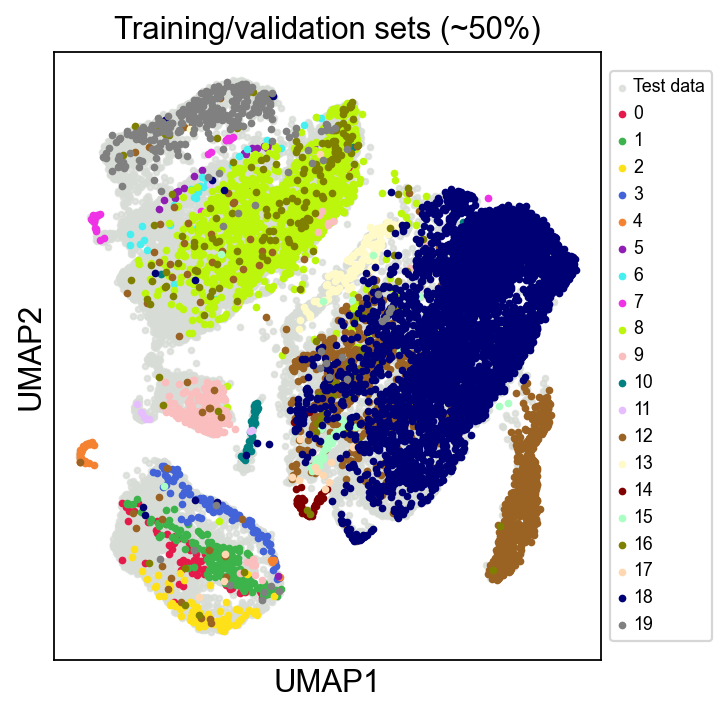

In [63]:
viz_training_data(rna_sing, tot_lab, tot_ideal_ind, cell_types, rna_sing.obsm['X_umap'], 'UMAP', sasha_trubet,
                  'Training/validation sets (~50%)', (6, 5), 0.75)

In [64]:
learning_rate = 0.025  # altering learning rate to change how much neural net can adjust during each training epoch
training_epochs = 500
batch_size = 100
display_step = 5

In [58]:
for i in range(len(tot_lab)):
    try:
        labels_onehot[i, tot_lab[i]] = 1
    except IndexError as e:
        print(f"IndexError at i={i}, tot_lab[i]={tot_lab[i]}")
        # Add more information if needed, such as the current shape of labels_onehot
        print("Current shape of labels_onehot:", labels_onehot.shape)
        # Add any other relevant information for debugging
        raise e  # Re-raise the exception to terminate the execution

IndexError at i=8655, tot_lab[i]=19
Current shape of labels_onehot: (8958, 19)


IndexError: index 19 is out of bounds for axis 1 with size 19

In [59]:
unique_labels = np.unique(tot_lab)
print("Unique labels:", unique_labels)

Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19]


(8958, 19)

In [65]:
tot_lab_onehot = one_hot_encode(tot_lab)
all_train_ind = np.array([])
ideal_ = np.argmax(tot_lab_onehot, axis=1)
train_split = 0.5
for k in np.unique(ideal_):
    all_ind = np.where(ideal_ == k)[0]  # randomly select half for training, other half goes to validation
    train_ind = np.random.choice(all_ind, round(train_split*len(all_ind)), replace=False)
    all_train_ind = np.concatenate((all_train_ind, train_ind))

In [66]:
total_predicted_lab, tot_prob, colorm, pred = cell_type_classifier(tot_lab_onehot, tot_traindata,
                                                                   tot_testdata,
                                                                   all_train_ind,
                                                                   learning_rate, training_epochs, batch_size,
                                                                   display_step)

2023-11-17 12:21:48.383414: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled


Epoch: 0005 cost= 0.728899815
Epoch: 0010 cost= 0.263503507
Epoch: 0015 cost= 0.046610741
Epoch: 0020 cost= 0.018253703
Epoch: 0025 cost= 0.008539804
Epoch: 0030 cost= 0.005937599
Epoch: 0035 cost= 0.003210084
Epoch: 0040 cost= 0.002887337
Epoch: 0045 cost= 0.002187762
Epoch: 0050 cost= 0.001394938
Epoch: 0055 cost= 0.001240824
Epoch: 0060 cost= 0.001053999
Epoch: 0065 cost= 0.001037658
Epoch: 0070 cost= 0.001099523
Epoch: 0075 cost= 0.000826657
Epoch: 0080 cost= 0.000624590
Epoch: 0085 cost= 0.000653571
Epoch: 0090 cost= 0.000569246
Epoch: 0095 cost= 0.000530811
Epoch: 0100 cost= 0.000542584
Epoch: 0105 cost= 0.000460899
Epoch: 0110 cost= 0.000379077
Epoch: 0115 cost= 0.000416608
Epoch: 0120 cost= 0.000370291
Epoch: 0125 cost= 0.000390195
Epoch: 0130 cost= 0.000314439
Epoch: 0135 cost= 0.000321644
Epoch: 0140 cost= 0.000294121
Epoch: 0145 cost= 0.000295738
Epoch: 0150 cost= 0.000295721
Epoch: 0155 cost= 0.000249505
Epoch: 0160 cost= 0.000240543
Epoch: 0165 cost= 0.000230173
Epoch: 017

In [67]:
total_lab, total_prob = process_label(tot_prob, tot_lab, total_predicted_lab, tot_ideal_ind, rna_sing, 0.8)

In [68]:
cluster2annotation = { 0: 'CD4 T cell', 1: 'CD8 T cell', 2:'Treg',3:'NK',4:'B cell',5: 'cDC1',6:'cDC2',7:'pDC',
                8:'Mono/Macrophage',9: 'Neutrophil',
                10:'Mast cell',11: 'Basophil', 12:  'Fibroblast/Adipocyte',13: 'Endothelial',
                14: 'Keratinocyte',15: 'Pericyte/SMC',16: 'Fibro-adipogenic progenitor', 17:'Melanocyte',
              18: 'Tumor cell' , 19: 'mregDC', -1: 'Poorly classified' }

In [69]:
rna_sing.obs['nn_80'] = pd.Series(total_lab.astype('int')).map(cluster2annotation).values

In [71]:
rna_sing.obs['nn_80'].value_counts()

nn_80
Tumor cell                     8168
Mono/Macrophage                5922
Poorly classified              3331
Fibroblast/Adipocyte           2448
mregDC                         1378
CD8 T cell                      702
Neutrophil                      640
Treg                            542
NK                              509
Endothelial                     406
Fibro-adipogenic progenitor     303
Mast cell                       159
CD4 T cell                      137
Pericyte/SMC                     82
Keratinocyte                     75
B cell                           62
pDC                              50
cDC2                             45
cDC1                             36
Melanocyte                       14
Basophil                         11
Name: count, dtype: int64

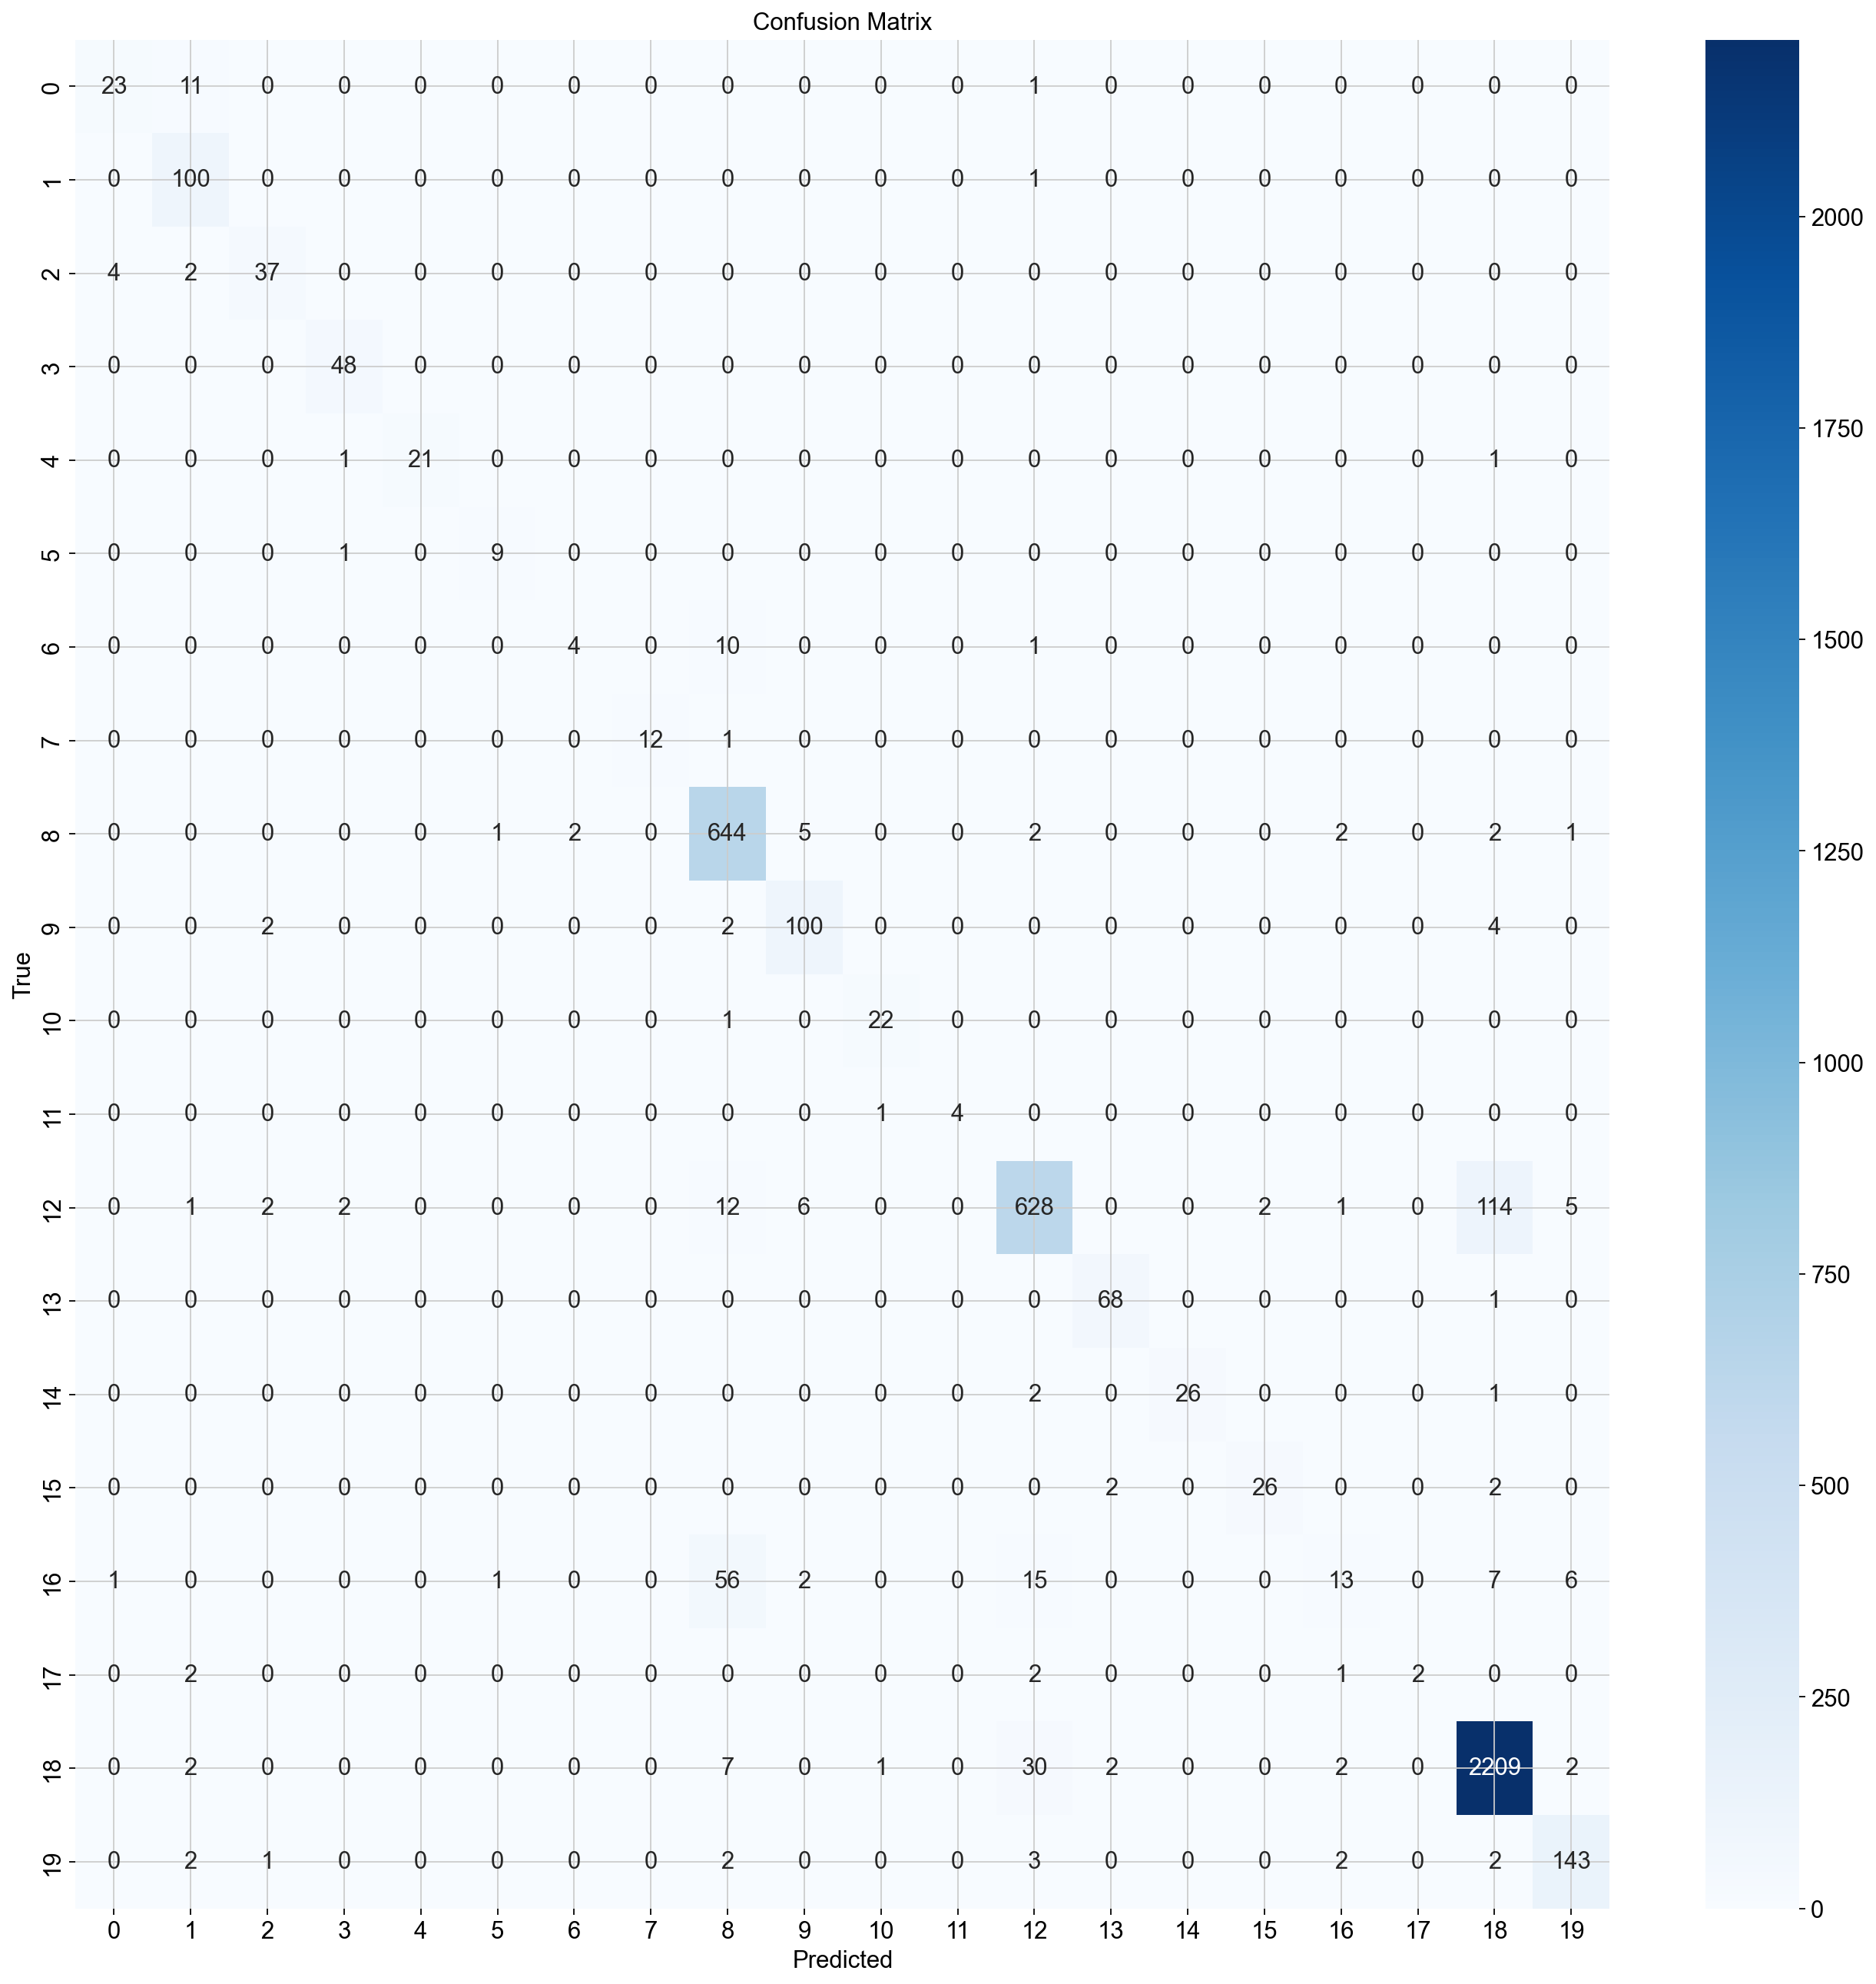

In [88]:
sns.heatmap(colorm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('Round2_confusion_matrix.pdf', format='pdf')
plt.show()


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


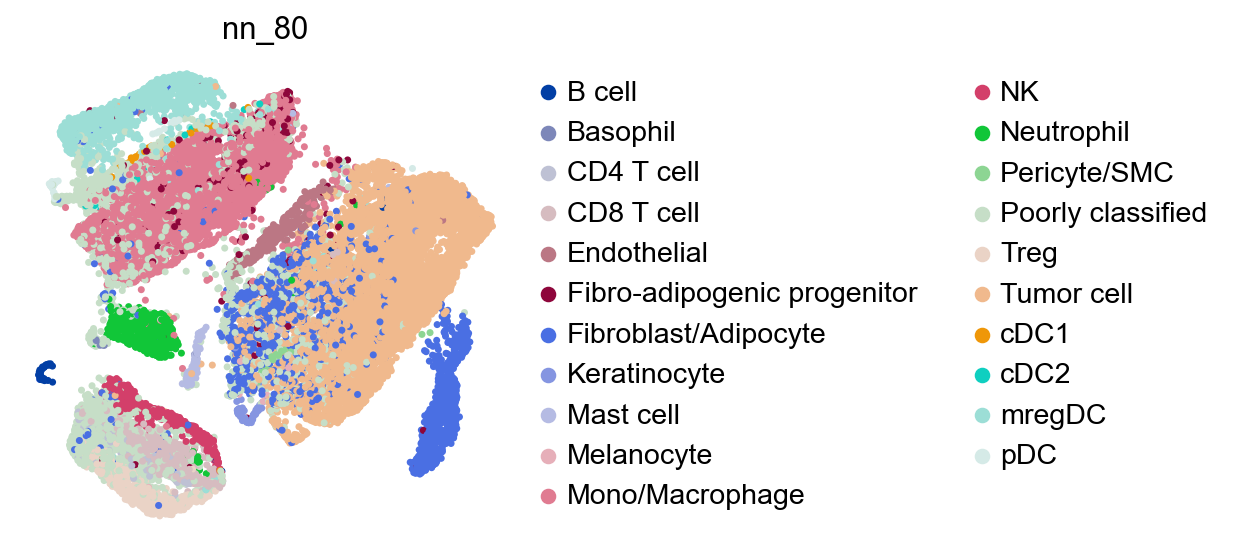

In [72]:
sc.pl.umap(rna_sing, color = 'nn_80', s = 40)




In [96]:
sc.tl.leiden(rna_sing, resolution = 0.6, key_added = "leiden_0.6")


/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


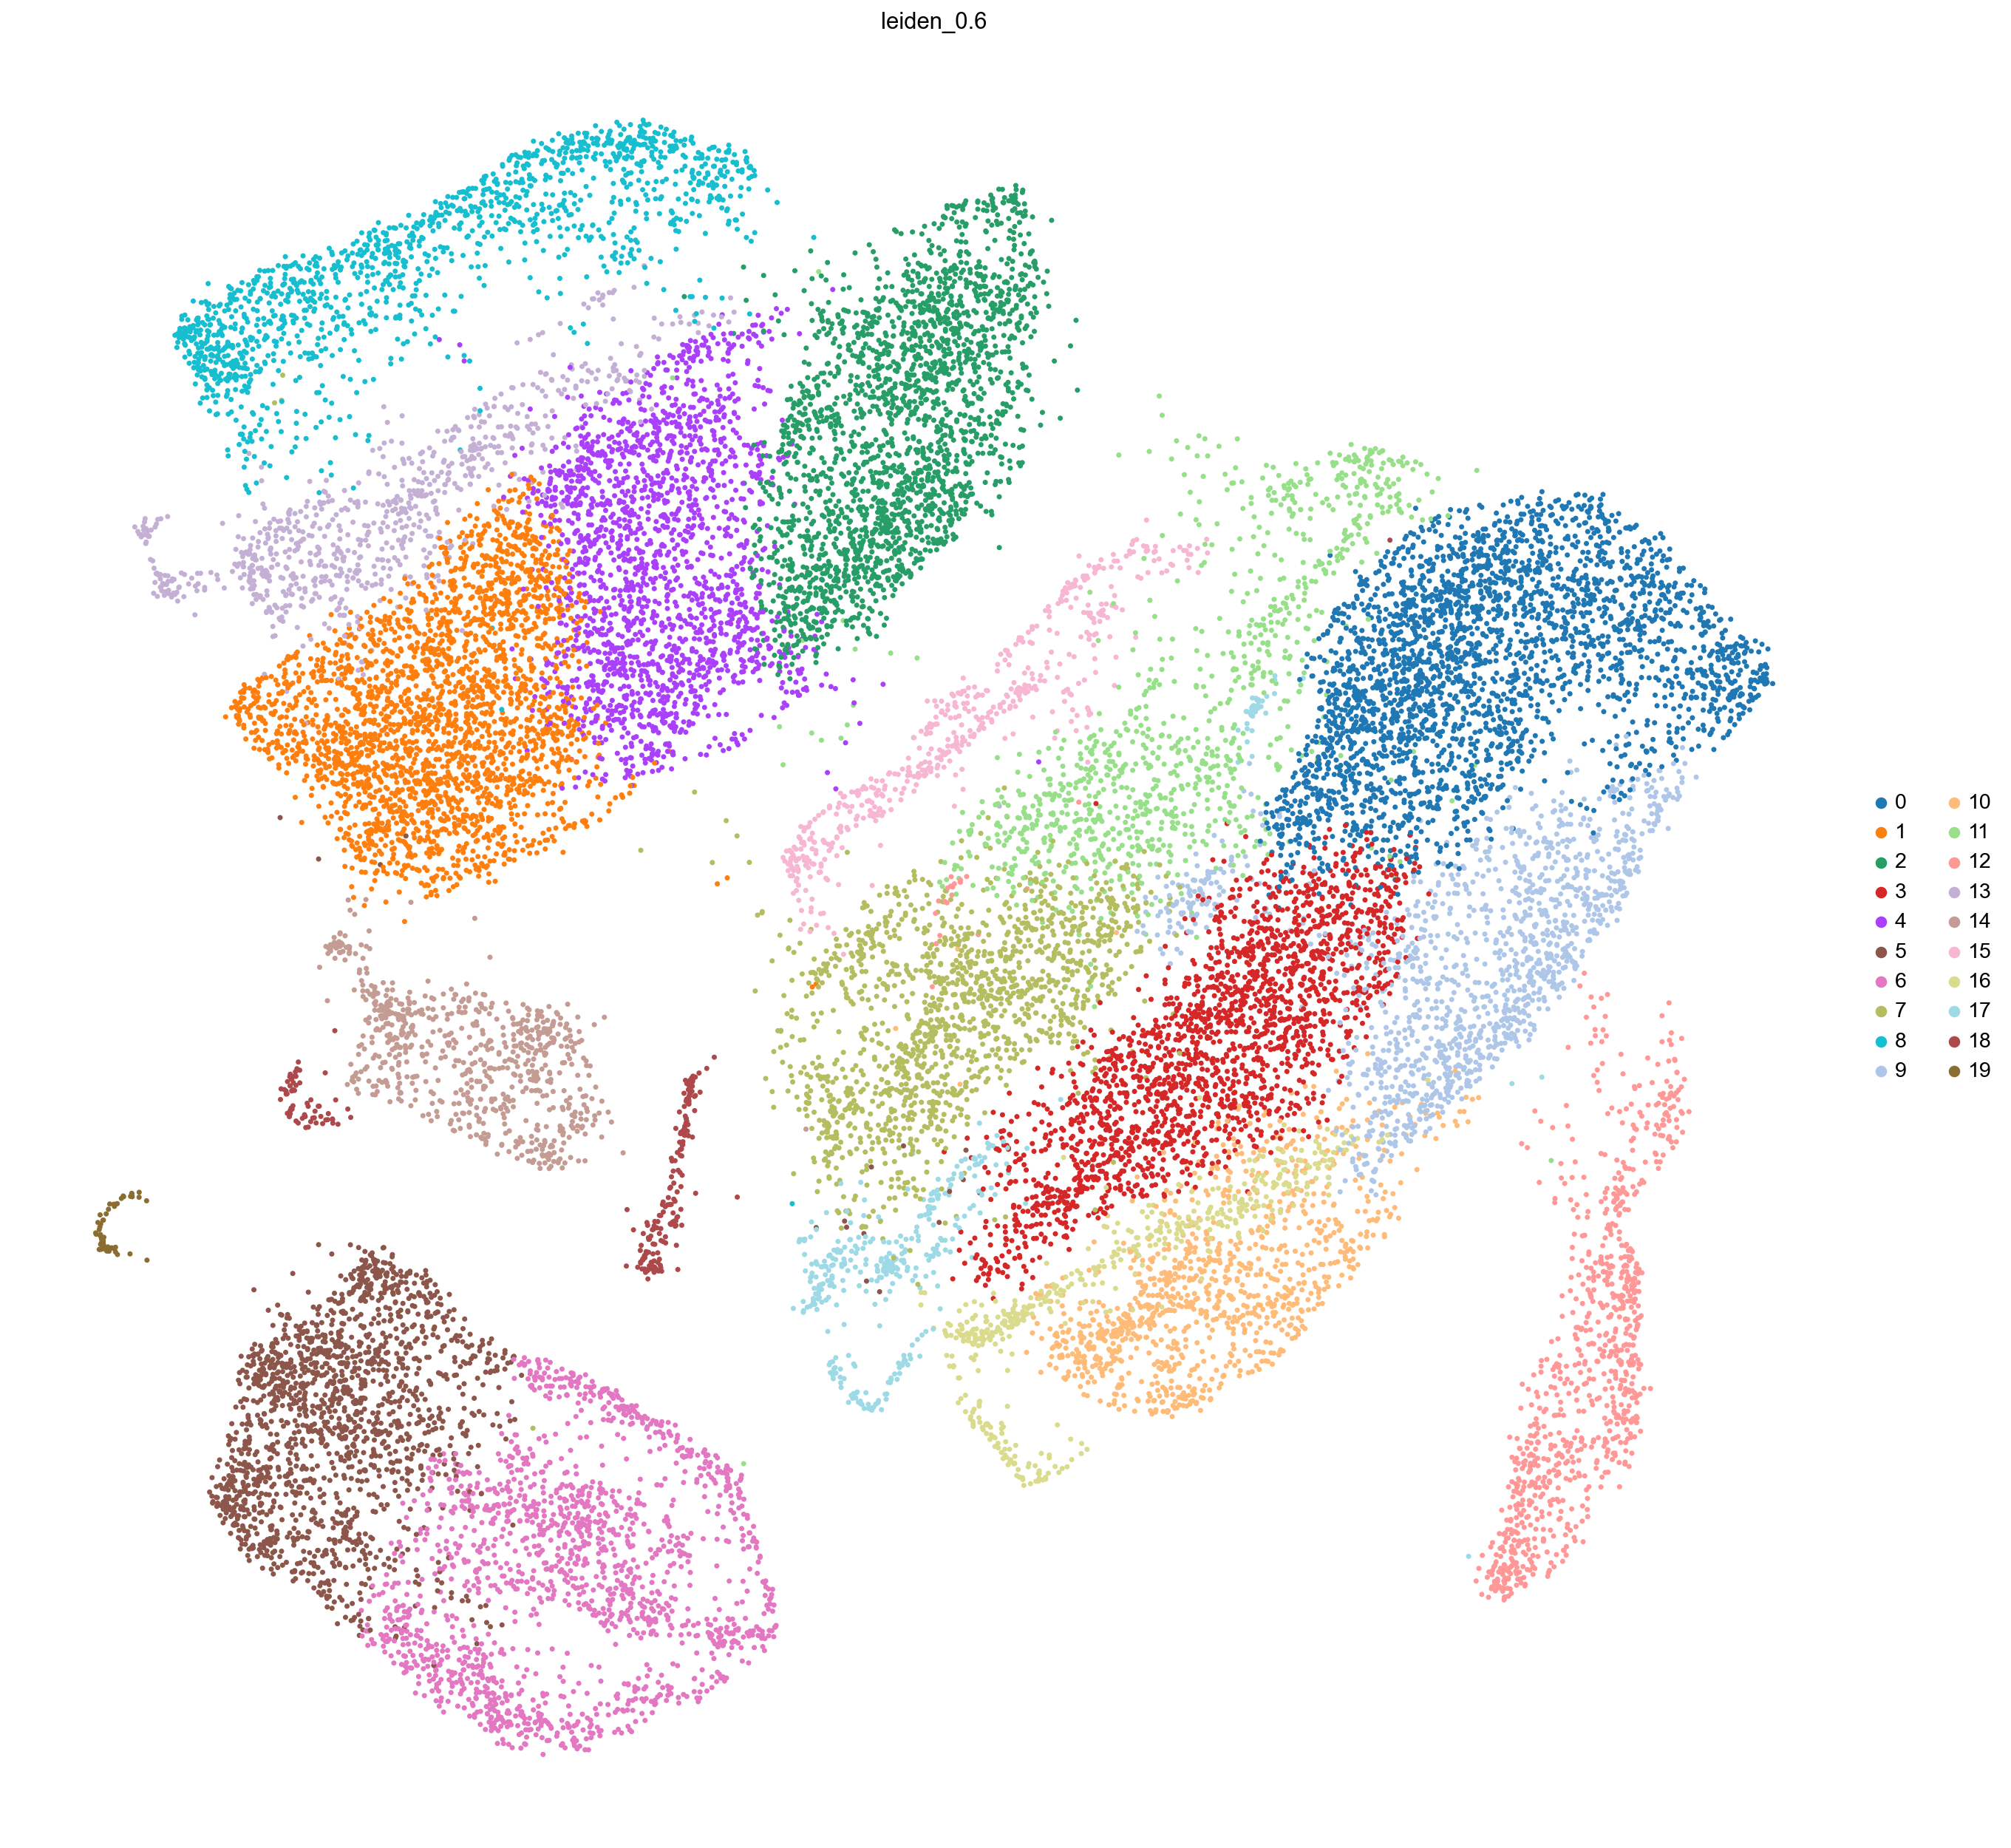

In [100]:
sc.pl.umap(rna_sing, color= 'leiden_0.6',s = 40)


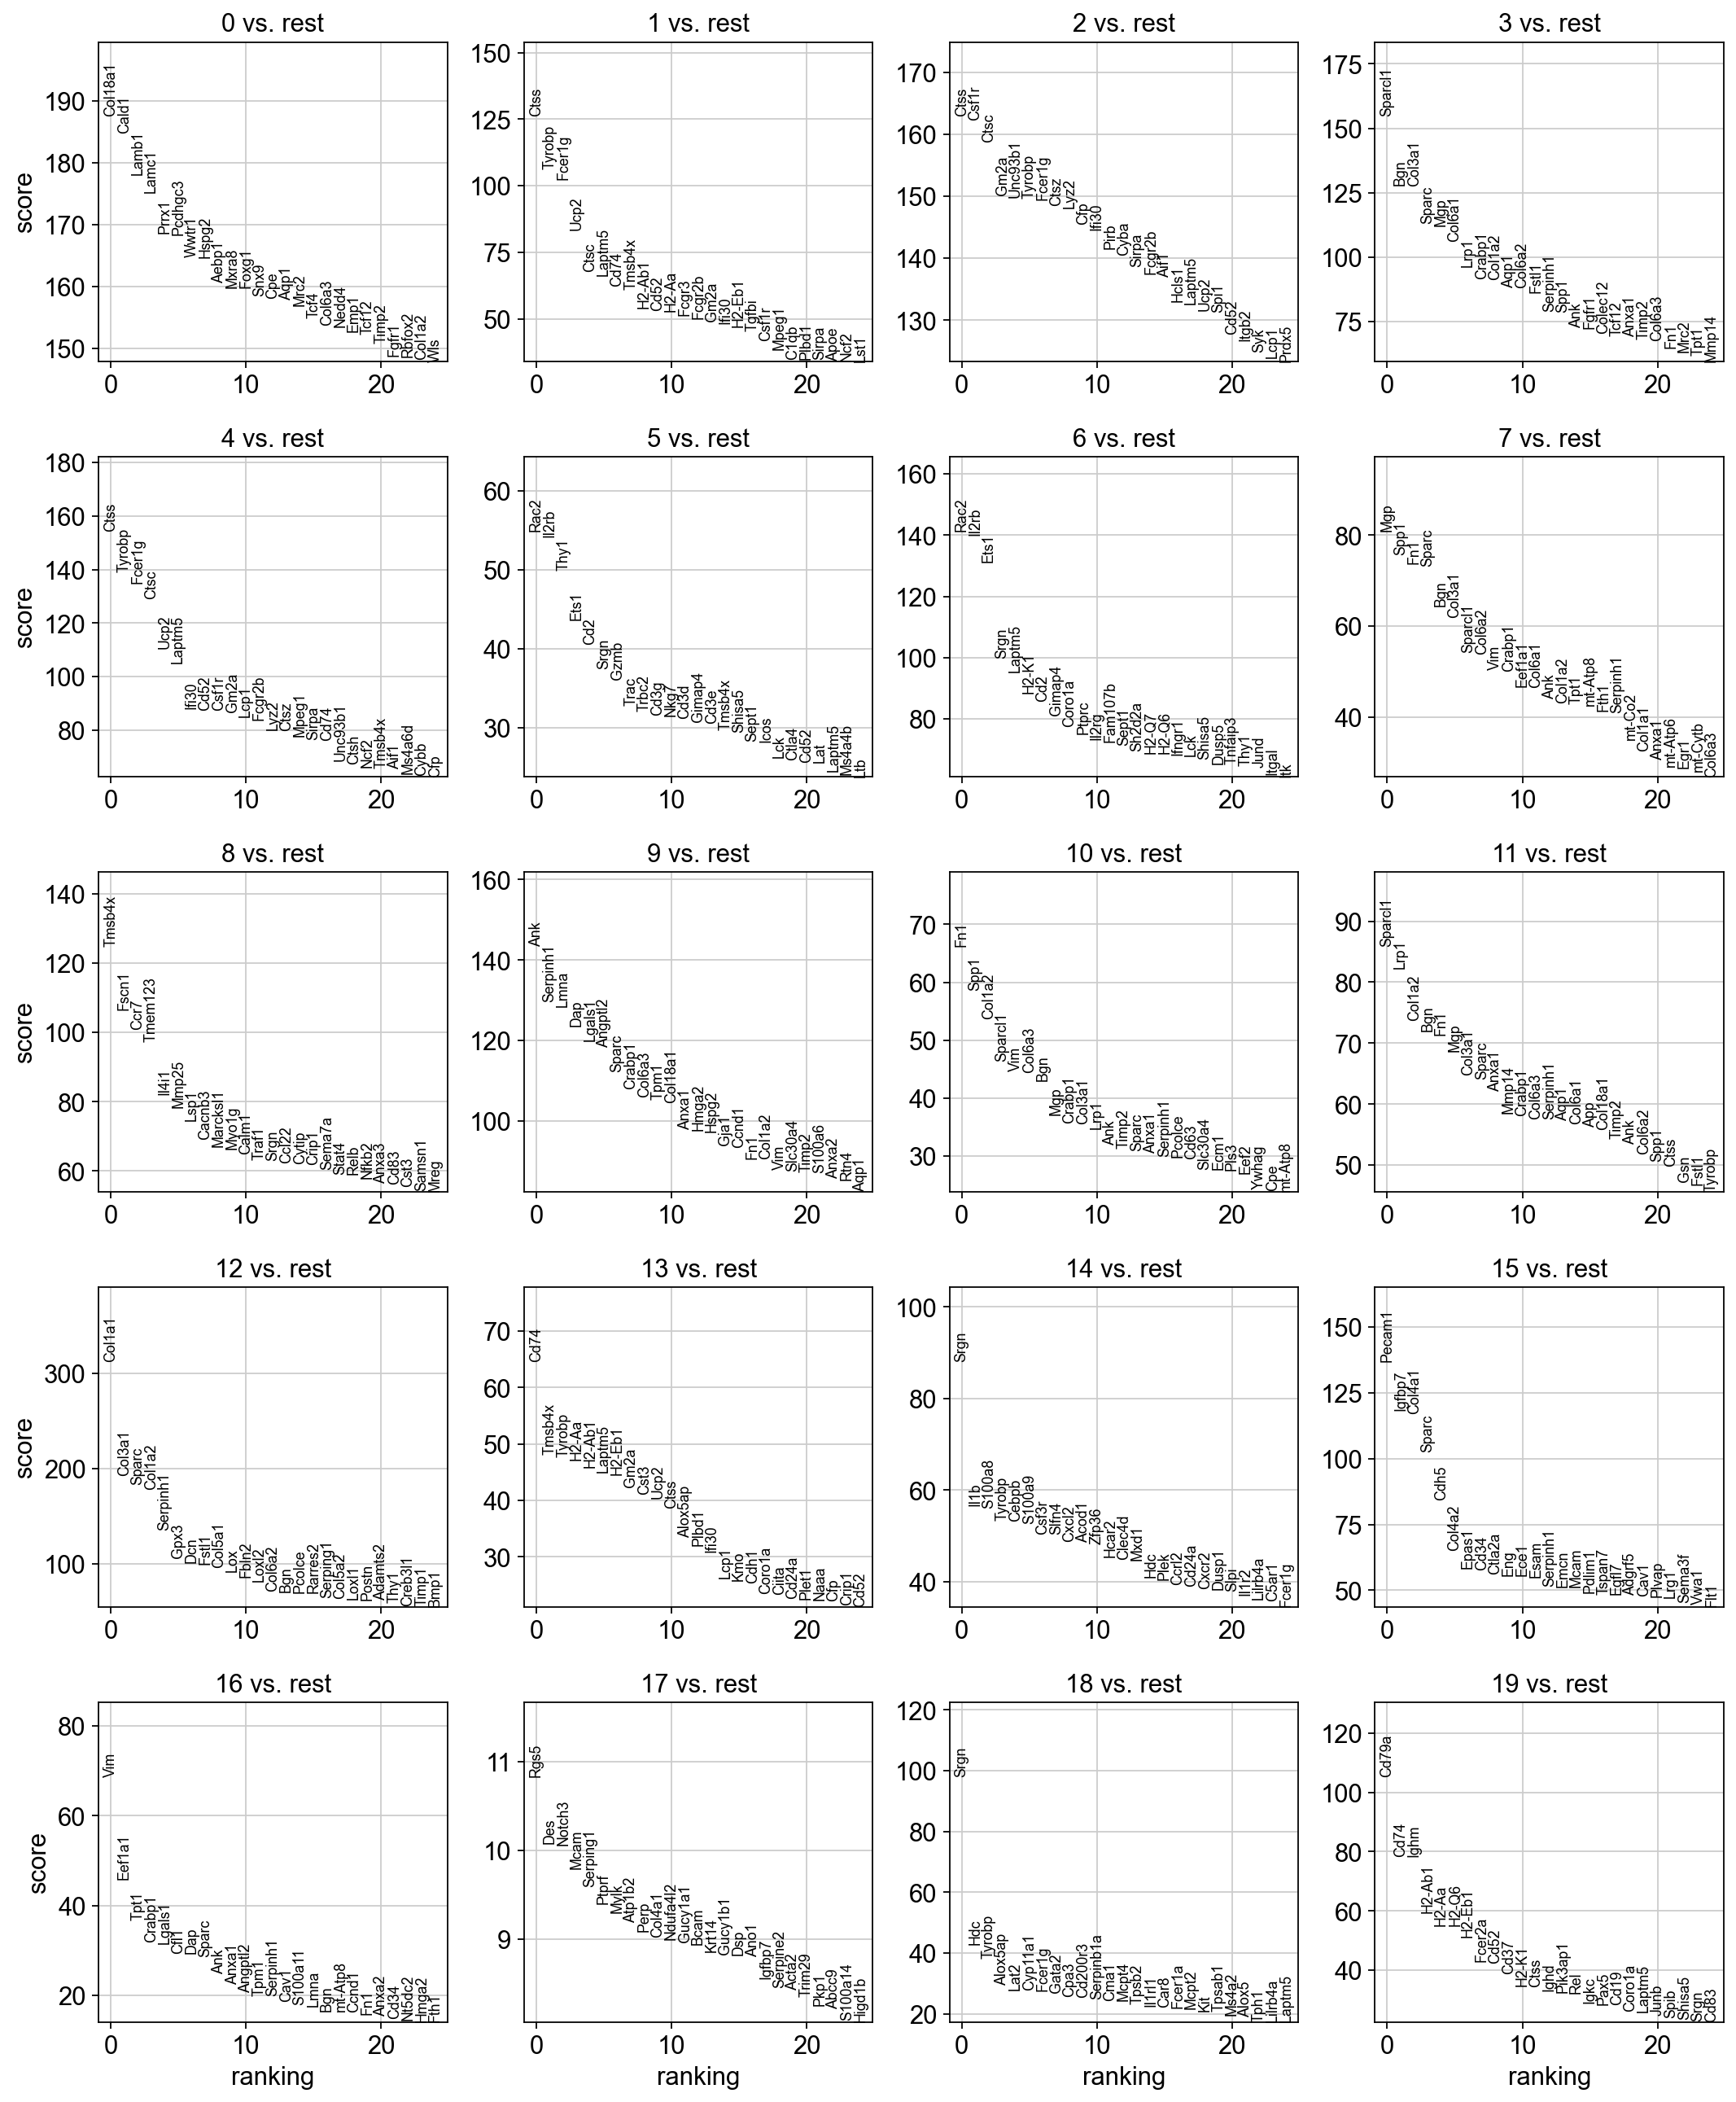

In [136]:
#rna_sing.obs
sc.tl.rank_genes_groups(rna_sing, 'leiden_0.6', method='t-test')
sc.set_figure_params(frameon=False, figsize=(4, 4))

sc.pl.rank_genes_groups(rna_sing, n_genes=25, sharey=False)





In [106]:
def encode_replicates(adata, rep_dict):
    rep = [None] * adata.shape[0]
    for z in np.arange(adata.shape[0]):
        if np.sum(adata.obsm['hash_onoff'][z]) > 0:
            z_arg = np.argmax(adata.obsm['hash_onoff'][z])
            rep[z] = 'R{}'.format(z_arg+1)
        else:
            rep[z] = 'R0'
    return rep

In [107]:
rna_sing.obs['replicate'] = encode_replicates(rna_sing, None)

In [108]:
def build_samplerep(adata, sample_slot, replicate_slot):
    sample_rep = [None] * adata.shape[0]
    for r in np.arange(adata.shape[0]):
        sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])
    return sample_rep

def group_nhoods(adata, min_connect, max_difflfc):
    adj_nhood = np.zeros((adata.obsm['nhoods'].shape[1], adata.obsm['nhoods'].shape[1]))

    # only considering single cells belonging to more than one
    overlap_ind = np.where(np.sum(adata.obsm['nhoods'], axis=1) > 1)[0]
    for g in overlap_ind:
        nhood_ind = np.where(adata.obsm['nhoods'][g, :].todense() == 1)[1]
        ij = list(itertools.permutations(nhood_ind, 2))
        for q in ij:
            adj_nhood[q] = adj_nhood[q] + 1

    # still need to filter adj matrix entries to zero by connections (< 3) and LFC match (diff > 0.25?)
    nonzero_ind = np.where(adj_nhood > 0)
    logFC = adata.uns['nhood_adata'].obs['logFC']
    for f in np.arange(len(nonzero_ind[0])):
        if adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] < min_connect or abs(logFC[nonzero_ind[0][f]] - logFC[nonzero_ind[1][f]]) > max_difflfc:
            adj_nhood[nonzero_ind[0][f], nonzero_ind[1][f]] = 0

    return adj_nhood

def plot_nhood_clusters(adata, cluster_labels, title, alpha=0.1, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan

    # plotting order
    ordered = nhood_adata.obs.sort_values('SpatialFDR', na_position='last').index[::-1]
    nhood_adata = nhood_adata[ordered]

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal

def plot_durable_clusters(adata, cluster_labels, title, alpha=0.1, beta=0.5, min_size=10, plot_edges=False):
    nhood_adata = adata.uns["nhood_adata"].copy()

    nhood_adata.obs["graph_color"] = cluster_labels
    nhood_adata.obs["graph_color"] = nhood_adata.obs["graph_color"].astype('category')

    clust_col = distinctipy.get_colors(len(np.unique(nhood_adata.obs["graph_color"])))
    clust_pal = {np.unique(nhood_adata.obs["graph_color"])[i]: clust_col[i] for i in range(len(clust_col))}

    nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] < alpha, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] > beta, "graph_color"] = np.nan
    nhood_adata.obs.loc[nhood_adata.obs["logFC"] < -beta, "graph_color"] = np.nan

    sc.pl.embedding(nhood_adata, "X_milo_graph",
                    color="graph_color", palette=clust_pal,
                    size=adata.uns["nhood_adata"].obs["Nhood_size"] * min_size,
                    edges=plot_edges, neighbors_key="nhood",
                    frameon=False,
                    title=title
                    )

    return nhood_adata.obs["graph_color"], clust_pal

def get_sc_louvain(adata, cluster_slot='louvain'):
    louvain_onehot = np.zeros((adata.uns['nhood_adata'].obs[cluster_slot].shape[0], (np.unique(adata.uns['nhood_adata'].obs[cluster_slot])[-2] + 1).astype('int')))
    for c in adata.uns['nhood_adata'].obs[cluster_slot].index:
        if adata.uns['nhood_adata'].obs[cluster_slot][c] < float('inf'):
            louvain_onehot[int(c), adata.uns['nhood_adata'].obs[cluster_slot][c].astype('int')] = 1

    # get single-cell louvain neighborhood cluster labels
    sc_onehot = adata.obsm['nhoods']*louvain_onehot
    sc_louvain = np.zeros(sc_onehot.shape[0])
    for t in np.arange(sc_onehot.shape[0]):
        if np.sum(sc_onehot[t, :]) == 0:
            sc_louvain[t] = -1
        else:
            sc_louvain[t] = np.argmax(sc_onehot[t, :])

    return sc_louvain.astype('int')

In [109]:
import itertools
from distinctipy import distinctipy

In [112]:
rna_sing = rna_sing[np.where(np.sum(rna_sing.obsm['hash_onoff'], axis=1) > 0)]

In [113]:
def remove_recompute(adata):
    del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
    sc.tl.pca(adata, svd_solver='auto')
    sc.pp.neighbors(adata)  # using with default parameters
    sc.tl.umap(adata)
    # sc.tl.diffmap(adata)
    return adata


/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_38234/836285930.py:2: ImplicitModificationWarning: Removing element `.obsm['X_umap']` of view, initializing view as actual.
  del adata.obsm['X_umap'], adata.obsm['X_pca'], adata.obsp, adata.uns
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/p

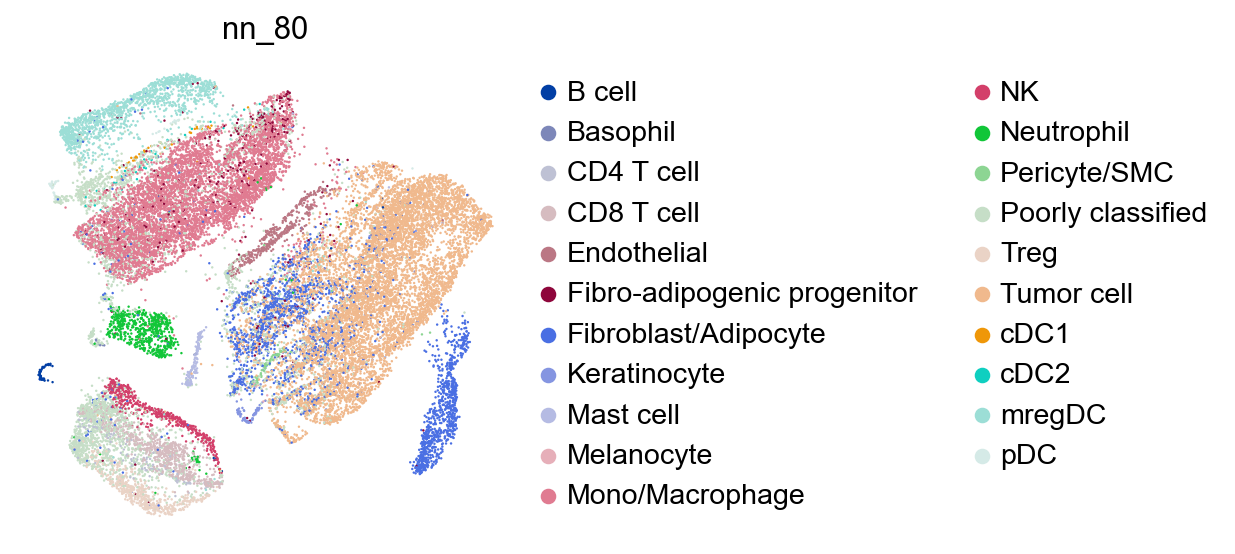

In [114]:
rna_sing = remove_recompute(rna_sing)
sc.pl.umap(rna_sing, color='nn_80')

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


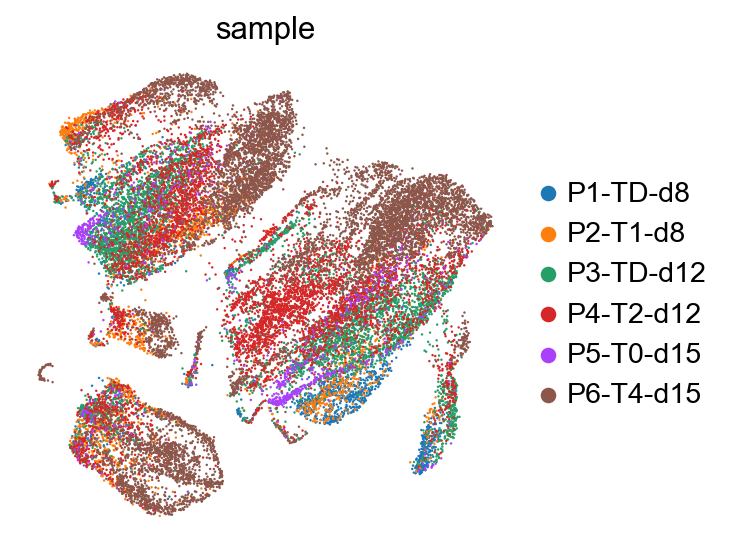

In [115]:
sc.pl.umap(rna_sing, color = 'sample')

In [119]:
dose_dict = {'P1-TD-d8': 0,
             'P2-T1-d8': 20,
             'P3-TD-d12': 40,
             'P4-T2-d12': 60,
             'P5-T0-d15':80,
             'P6-T4-d15' :100}
rna_sing.obs['cond_continuous'] = rna_sing.obs['sample'].map(dose_dict).astype(int)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


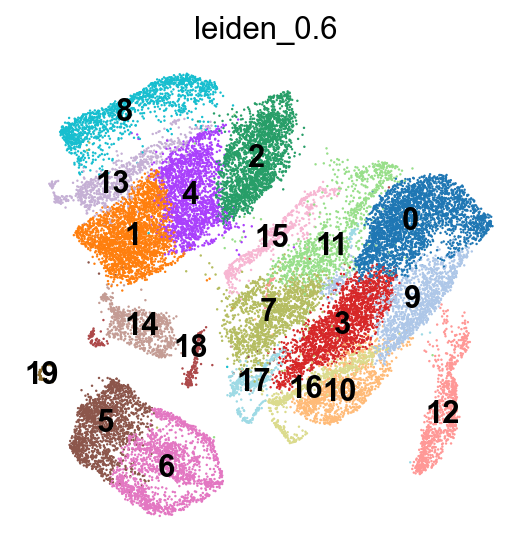

In [137]:
sc.pl.umap(rna_sing, color = 'leiden_0.6', legend_loc='on data')

In [ ]:
rna_sing

In [121]:
rna_sing.obs['sample_rep'] = build_samplerep(rna_sing, 'cond_continuous', 'replicate')

/var/folders/wb/0twtb9pj5rq2sw71djs3j1z00000gn/T/ipykernel_38234/1850070665.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_rep[r] = str(adata.obs[sample_slot][r]) + ' ' + str(adata.obs[replicate_slot][r])


In [124]:
import milopy  
import milopy.core as milo


In [125]:
milo.make_nhoods(rna_sing)

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:125: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[30.15218925 32.95627213 25.75842857 ... 48.68708801 34.18904495
 40.49551773]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  adata.obs.loc[adata.obs["nhood_ixs_refined"]


In [126]:
rna_sing.obs['rep_code'] = rna_sing.obs['sample_rep'].cat.codes

In [127]:
milo.count_nhoods(rna_sing, sample_col="rep_code")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [128]:
milo.DA_nhoods(rna_sing, design="~ cond_continuous")

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:234: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if design_df.dtypes[i].name == 'category':
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:306: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pvalues = pvalues[keep_nhoods][o]
/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/milopy/core.py:307: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To a

In [129]:
milo_results = rna_sing.uns["nhood_adata"].obs

/Users/anasuyadighe/anaconda3/envs/scrna/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


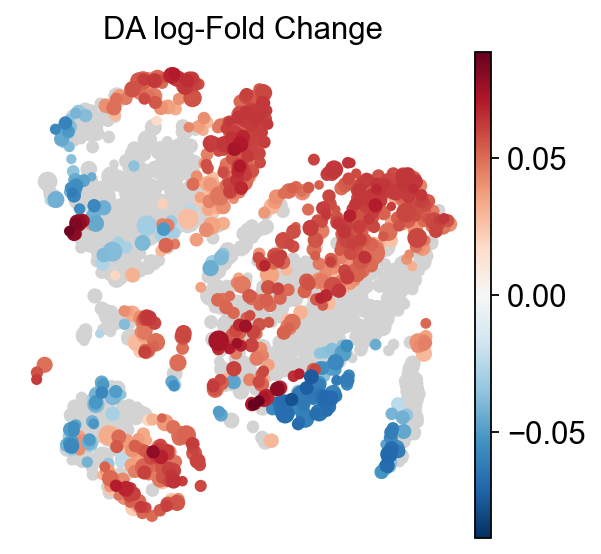

<Figure size 320x320 with 0 Axes>

In [130]:
milopy.utils.build_nhood_graph(rna_sing)
milopy.plot.plot_nhood_graph(rna_sing, alpha=0.1, min_size=5)
plt.tight_layout()

In [131]:
milopy.utils.annotate_nhoods(rna_sing, anno_col='nn_80')

In [ ]:
plt.hist(rna_sing.uns['nhood_adata'].obs["nhood_annotation_frac"])
plt.xlabel("celltype fraction")

In [134]:
rna_sing.uns['nhood_adata'].obs.loc[rna_sing.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.5, "nhood_annotation"] = "Mixed"

TypeError: Cannot setitem on a Categorical with a new category (Mixed), set the categories first